# Cell assemblies

In [14]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network
from connectivity import designed_matrix_sequences
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

In [25]:
def train_network_modular(N, h, dt, training_time, inter_sequence_time, sequences, tau_z, tau_z_post, tau_w,
                          epochs=1, max_w=1.0, min_w=None, save_w_history=False):

    w = np.zeros((N * h, N * h))
    w_history = [w]

    inter_sequence_steps = int(inter_sequence_time / dt)

    x_total = np.array([]).reshape(0, N * h)
    for epoch in range(epochs):
        for sequence in sequences:
            n_sequence = len(sequence)
            training_steps = int(training_time / dt)

            for element in sequence:
                x = np.zeros((training_steps, N * h))
                for time in range(training_steps):
                    for h_index in range(h):
                        x[time, element + h_index * N] = 1.0
                # Concatenate for the total history
                x_total = np.concatenate((x_total, x), axis=0)
                

            # Inter-sequence steps
            x = np.zeros((inter_sequence_steps, N * h))
            x_total = np.concatenate((x_total, x), axis=0)

    # Train the Z-filters and w
    z = np.zeros(N * h)
    z_post = np.zeros(N * h)

    z_history = np.zeros_like(x_total)
    z_post_history = np.zeros_like(x_total)

    for index, x_example in enumerate(x_total):
        z += (dt / tau_z) * (x_example - z)
        z_post += (dt / tau_z_post) * (x_example - z_post)
        z_history[index, :] = z
        z_post_history[index, :] = z_post

        normal = np.outer(z_post, z)
        # This is the pre-synaptic rule (check this statement)
        negative = np.outer(1 - z_post, z)
        if min_w is None:
            w += (dt / tau_w) * ((max_w - w) * normal - negative)
        else:
            w += (dt / tau_w) * ((max_w - w) * normal + (min_w - w) * negative)

        if save_w_history:
            w_history.append(np.copy(w))


    dic = {}
    dic['w'] = w
    dic['x'] = x_total
    dic['z'] = z_history
    dic['z_post'] = z_post_history

    if save_w_history:
        dic['w_history'] = np.array(w_history)

    return dic

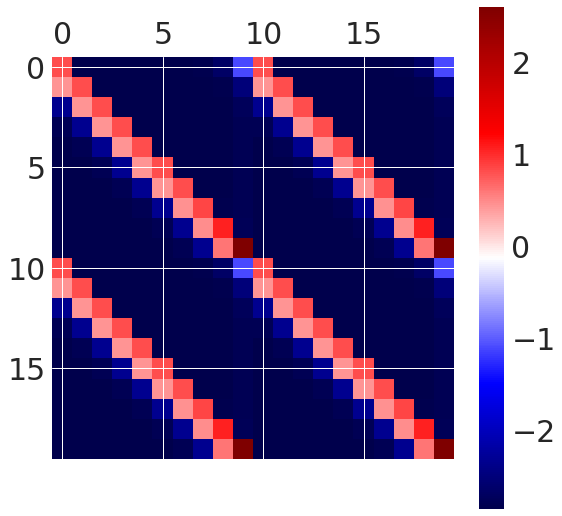

In [26]:
N = 10
h = 2
tau_z = 0.050
tau_z_post = 0.005
tau_w = 0.100

training_time = 0.100
inter_sequence_time = 0.000
dt = 0.001
sequence1 = [0, 1, 2, 3]
sequence2 = [4, 5, 6, 7, 8, 9]
sequences = [sequence1, sequence2]

dic = train_network_modular(N, h, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=3, max_w=5.0, min_w=-3.0)

w = dic['w']
x_total = dic['x']
z_history = dic['z']
z_post_history = dic['z_post']

plt.matshow(w, cmap='seismic')
plt.colorbar();

In [27]:
x_total

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

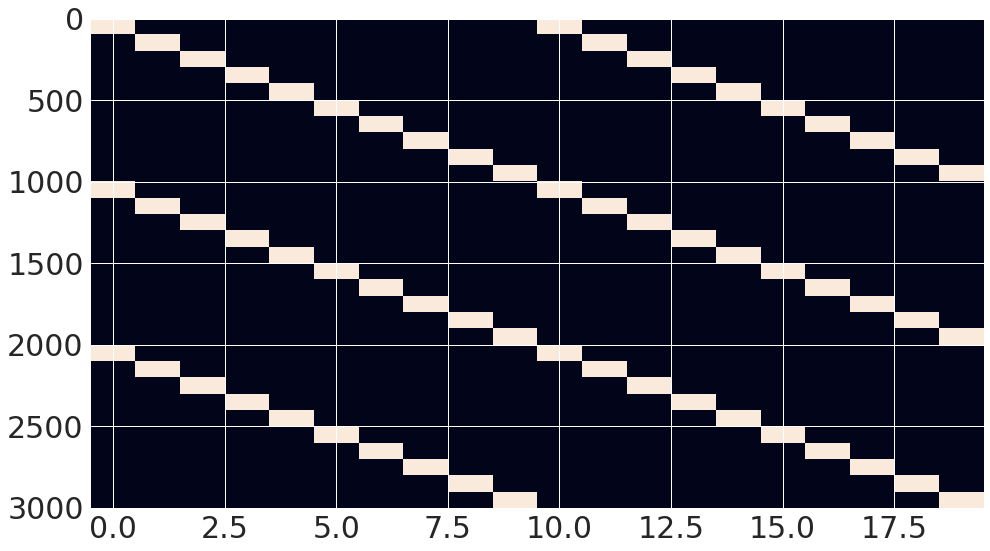

In [28]:
plt.imshow(x_total, aspect='auto')

In [30]:
G = 100.0
tau_m = 0.010
T = 2.0
I_cue = 0
T_cue = 0.050
dt = dt
threshold = 0.3

dic = run_network_recall(N * h, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


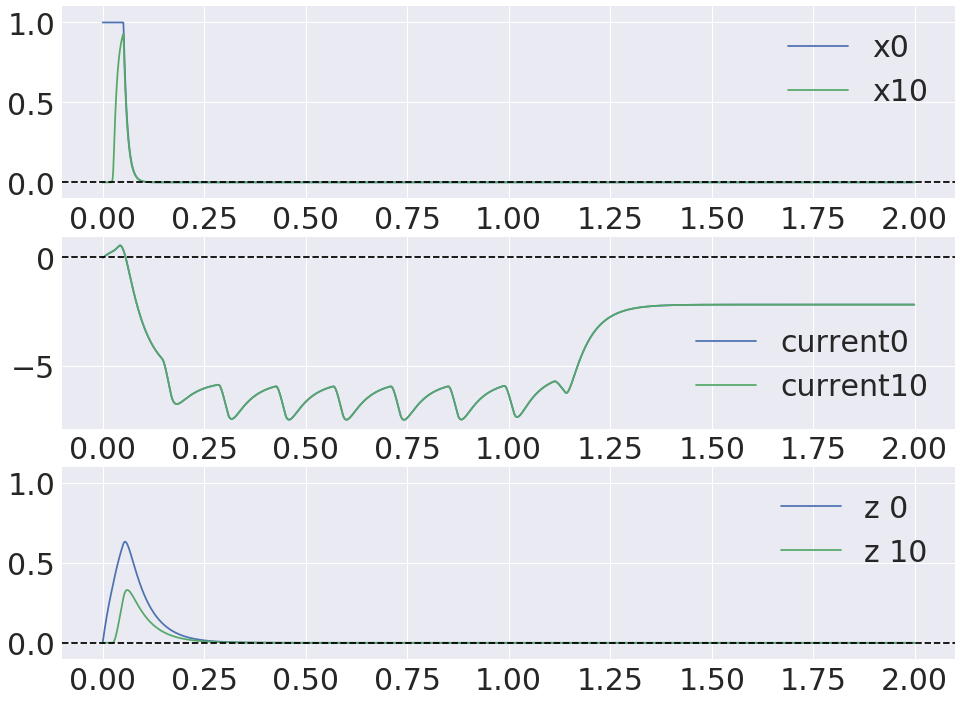

In [33]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [0, 10]
# patterns = sequence
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern], label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], label='current' + str(pattern))
    ax3.plot(time, z_history[:, pattern], label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')
ax1.legend();
ax1.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(0, ls='--', color='black')
ax2.legend();

ax3.axhline(0, ls='--', color='black')
ax3.legend();

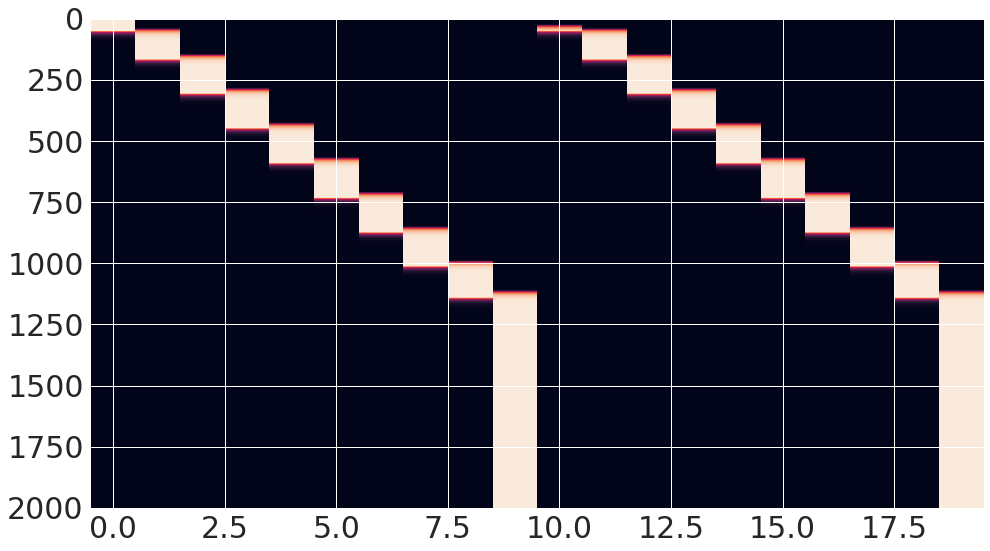

In [34]:
plt.imshow(x_history, aspect='auto')

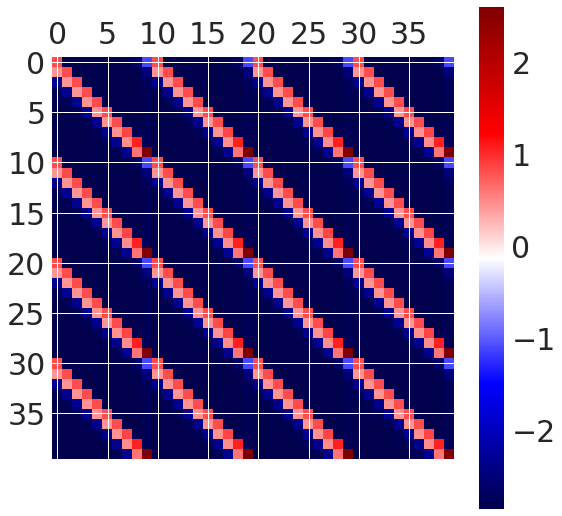

In [18]:
N = 10
h = 4
tau_z = 0.050
tau_z_post = 0.005
tau_w = 0.100

training_time = 0.100
inter_sequence_time = 0.000
dt = 0.001
sequence1 = [0, 1, 2, 3]
sequence2 = [4, 5, 6, 7, 8, 9]
sequences = [sequence1, sequence2]

dic = train_network_modular(N, h, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=3, max_w=5.0, min_w=-3.0)

w = dic['w']
x_total = dic['x']
z_history = dic['z']
z_post_history = dic['z_post']

plt.matshow(w, cmap='seismic')
plt.colorbar();